In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from copy import deepcopy as copy

No Bottleneck unit testing available.


In [5]:
import objFuncs
from objFuncs import VM
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history
from objFuncs import flame_utils_kilean as flame_utils

objFuncs version: 1.0.2. updated on 2023-12-19


In [6]:
decision_CSETs=[
    'FS2_BTS:PSC2_D3930:I_CSET',
    'FS2_BTS:PSC2_D3945:I_CSET',
#     'FS2_BTS:PSC2_D3962:I_CSET',
]
objective_goal = { 
    'FS2_BTS:BPM_D3958:XPOS_RD' : 0.0,
    'FS2_BTS:BPM_D4006:XPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

n_condition = 3
conditional_SETs = {
    'FS2_BTS:PSQ_D3950:I_CSET':[70,100, 70],
    'FS2_BTS:PSQ_D3955:I_CSET':[70, 70,100],
}

In [7]:
fm_vms = []
for i in range(n_condition):
    fm_vm = flame_utils.VM(
            latfile = "test_FS2a_20231130_040841_read.lat",
            decision_CSETs = decision_CSETs,
            objective_RDs  = objective_RDs,
            conditional_SETs = {key:val[i] for key, val in conditional_SETs.items()},
        )
    m0 = copy(fm_vm.fm.bmstate.moment0)
    m0[0] = 2.
    fm_vm.fm.bmstate.moment0 = m0
    fm_vms.append(fm_vm)

'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat


In [8]:
fm_vms[0].fm.get_df_by_type('orbtrim')

,realpara,tm_xkick,name,z,type,L,tm_ykick
index,,,,,,,
2,1.0,-0.003150,FS2_BTS:DCH_D3930,0.576498,orbtrim,0.0,NaN
3,1.0,NaN,FS2_BTS:DCV_D3930,0.576498,orbtrim,0.0,0.002170
11,1.0,0.002279,FS2_BTS:DCH_D3945,2.101498,orbtrim,0.0,NaN
12,1.0,NaN,FS2_BTS:DCV_D3945,2.101498,orbtrim,0.0,0.000384
22,1.0,0.000000,FS2_BTS:DCH_D3962,3.840141,orbtrim,0.0,NaN
23,1.0,NaN,FS2_BTS:DCV_D3962,3.840141,orbtrim,0.0,0.000000


In [9]:
fm_vms[0].fm.get_df_by_type('quadrupole')

,name,z,aper,B2,type,L,radius
index,,,,,,,
5,FS2_BTS:QH_D3934,0.876498,0.025,19.904501,quadrupole,0.25,0.02375
7,FS2_BTS:QV_D3940,1.451498,0.025,-16.525398,quadrupole,0.25,0.02375
14,FS2_BTS:QV_D3950,2.451498,0.025,-8.301003,quadrupole,0.25,0.02375
16,FS2_BTS:QH_D3955,2.951498,0.025,8.301003,quadrupole,0.25,0.02375
27,FS2_BTS:Q_D3994,6.822192,0.025,-0.000000,quadrupole,0.40,0.03500
29,FS2_BTS:Q_D4000,7.449498,0.025,0.000000,quadrupole,0.26,0.02000


In [10]:
fm_vms[0].fm.get_df_by_type('bpm')

,name,type,L,z
index,,,,
9,FS2_WD12:BPM_D3943,bpm,0.0,1.920204
18,FS2_BTS:BPM_D3958,bpm,0.0,3.367353
31,FS2_BTS:BPM_D4006,bpm,0.0,8.201242


In [11]:
machineIO_vms = []
for fm_vm in fm_vms:
    machineIO_vms.append(
        VM(
            x0 = fm_vm.x0,
            fun = fm_vm,
            decision_CSETs = decision_CSETs,
            objective_RDs = objective_RDs,
            fetch_data_time_span = 0.2,
        )
    )

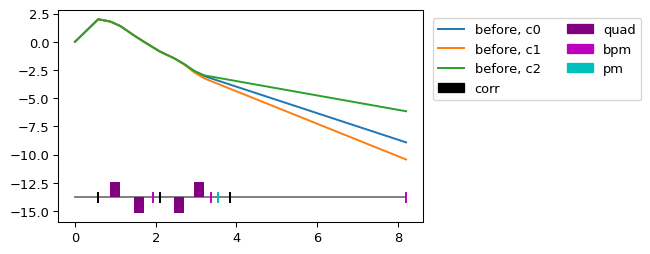

In [12]:
r0 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r0.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
for i,r0_ in enumerate(r0):
    ax.plot(r0_['pos'],r0_['xcen'],label='before, c'+str(i))
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [13]:
objFuncs._global_machineIO.fetch_data = machineIO_vms[0].fetch_data
objFuncs._global_machineIO.ensure_set = machineIO_vms[0].ensure_set
objFuncs._global_machineIO._test = True

In [14]:
fm_vm.x0

[-15.990100000000002, 11.56861]

In [15]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min= -40,
    decision_max=  40,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

for i in range(n_condition):
    res.residualObj[i].machineIO = machineIO_vms[i]

[condition_controller] ======== class info ========
init_time: 2023-12-21 09:48:06.451314
class_hierarchy: [
    objFuncBase]
decision_CSETs: [
    FS2_BTS:PSQ_D3950:I_CSET, FS2_BTS:PSQ_D3955:I_CSET]
decision_min: [70. 70.]
decision_max: [100. 100.]
decision_bounds: [[ 70 100]
 [ 70 100]]
decision_RDs: [
    FS2_BTS:PSQ_D3950:I_RD, FS2_BTS:PSQ_D3955:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [
    0.5, 0.5]

[condition 0] ======== class info ========
init_time: 2023-12-21 09:48:06.497104
class_hierarchy: [
    residualObj, objFuncBase]
decision_CSETs: [
    FS2_BTS:PSC2_D3930:I_CSET, FS2_BTS:PSC2_D3945:I_CSET]
decision_min: [-40. -40.]
decision_max: [40. 40.]
decision_bounds: [[-40.  40.]
 [-40.  40.]]
decision_RDs: [
    FS2_BTS:PSC2_D3930:I_RD, FS2_BTS:PSC2_D3945:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_ta

======== class info ========
init_time: 2023-12-21 09:48:06.568409
class_hierarchy: [
    residualObj, objFuncBase]
decision_CSETs: [
    FS2_BTS:PSC2_D3930:I_CSET, FS2_BTS:PSC2_D3945:I_CSET]
decision_min: [-40. -40.]
decision_max: [40. 40.]
decision_bounds: [[-40.  40.]
 [-40.  40.]]
decision_RDs: [
    FS2_BTS:PSC2_D3930:I_RD, FS2_BTS:PSC2_D3945:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: .residual_condition1
logging_fname: None
x0: [
    -15.9901, 11.56861]
objective_goal:
    FS2_BTS:BPM_D3958:XPOS_RD: 0.0
    FS2_BTS:BPM_D4006:XPOS_RD: 0.0
objective_norm:
    FS2_BTS:BPM_D3958:XPOS_RD: 1.0
    FS2_BTS:BPM_D4006:XPOS_RD: 1.0
objective_weight:
    FS2_BTS:BPM_D3958:XPOS_RD: 1.0
    FS2_BTS:BPM_D4006:XPOS_RD: 1.0
objective_RDs: [
    FS2_BTS:BPM_D3958:XPOS_RD, FS2_BTS:BPM_D4006:XPOS_RD]

[condition 2] ======== class info ========
init_time: 2023-12-21 09:48:06.669121
class_hierarchy: [
    residualObj, objFuncBase]


In [16]:
plot0 = plot_obj_history(
    res.residualObj[0].history['decision_CSETs'],
    title='condition0',
)
plot1 = plot_obj_history(
    res.residualObj[1].history['decision_CSETs'],
    title='condition1',
)
plot2 = plot_obj_history(
    res.residualObj[2].history['decision_CSETs'],
    title='condition2',
)
plot_control = plot_obj_history(
    res.condition_controller.history['decision_CSETs'],
    title='condition controller',
)

plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)

class add_delay:
    def __init__(self):
        pass
    def __call__(self):
        time.sleep(5)
    def close(self):
        pass
    
add_delay = add_delay()
    
callbacks = [add_delay,plot0,plot1,plot2,plot_control,plot_conditions_RDs,plot_objectives_var,add_delay]
# callbacks = []

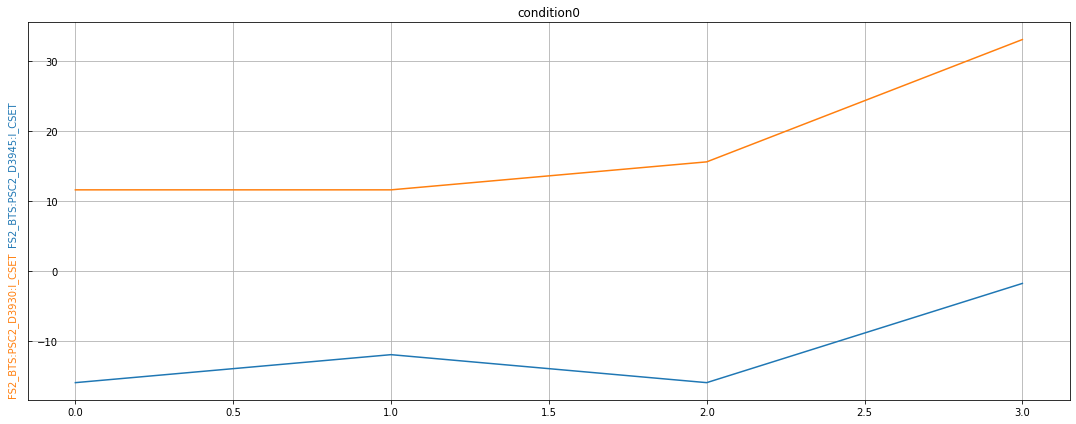

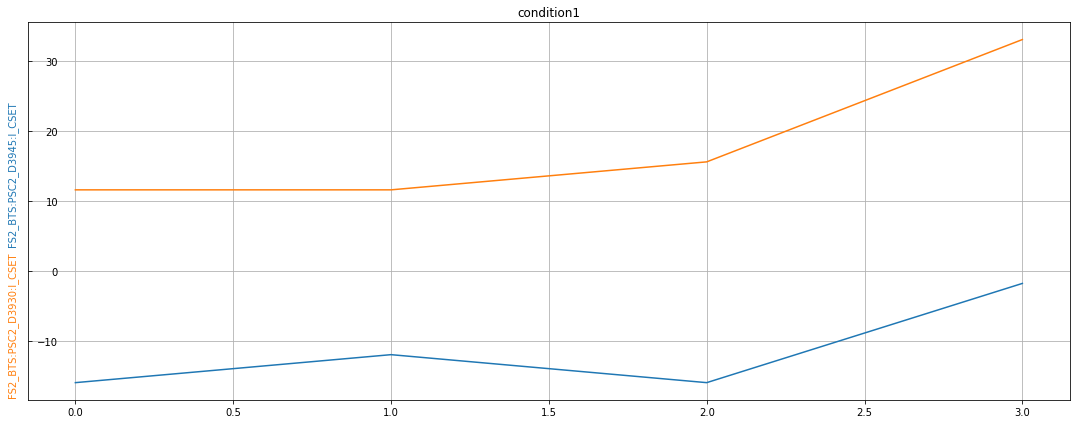

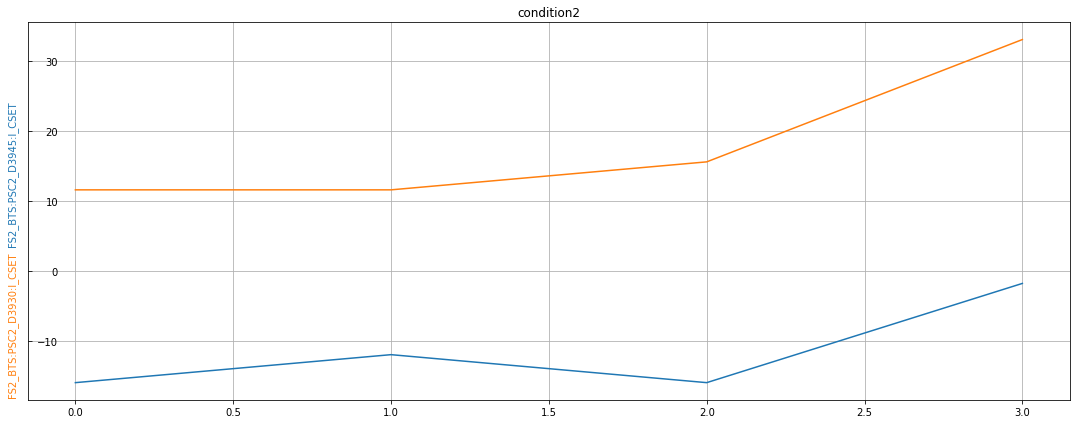

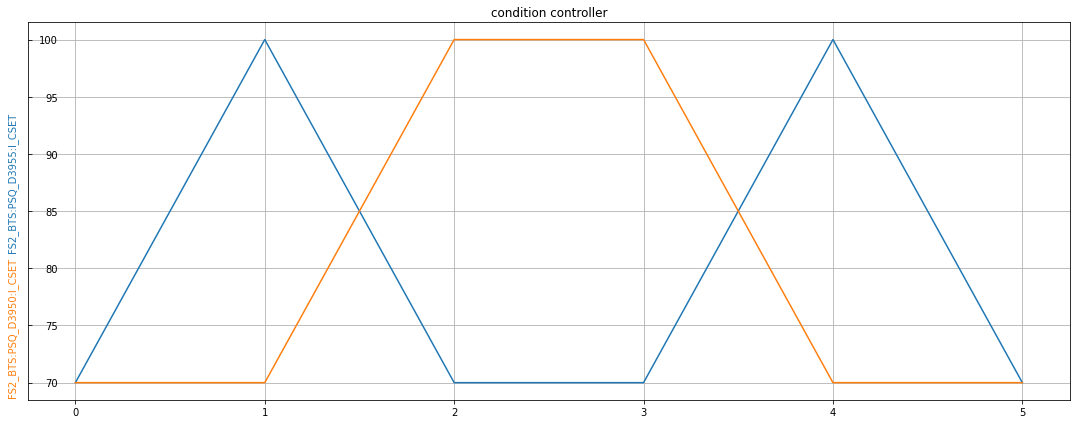

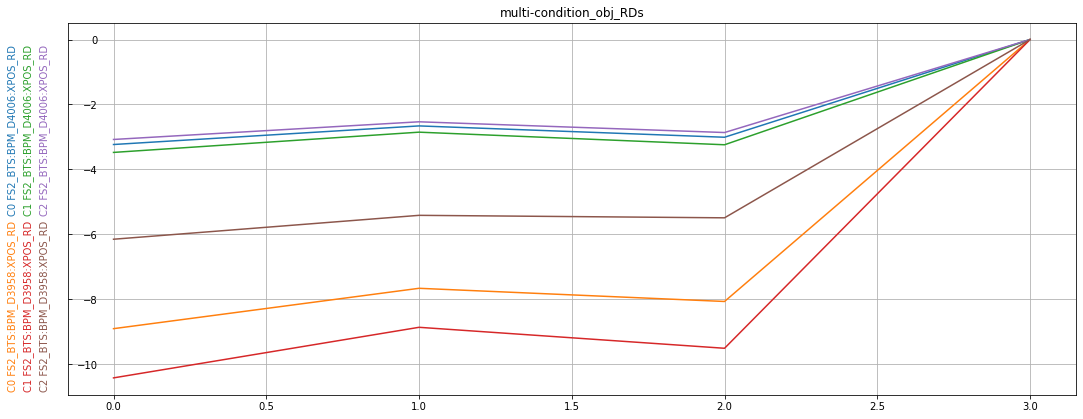

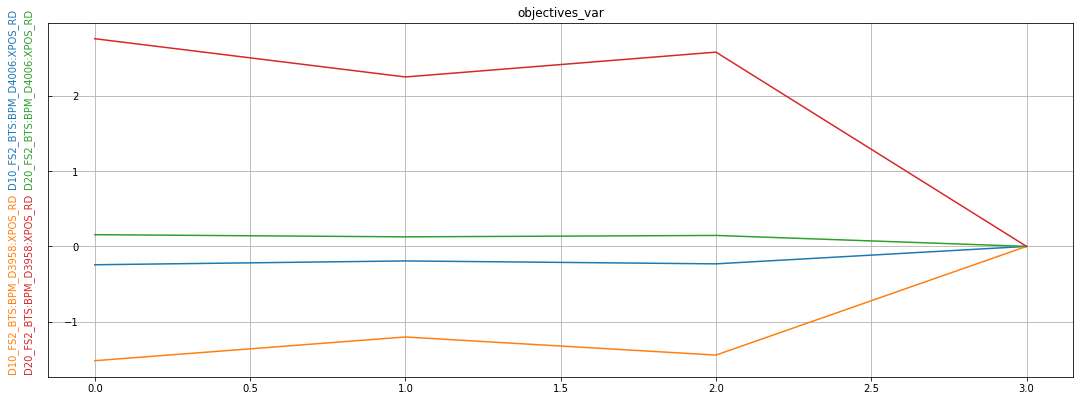

In [17]:
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

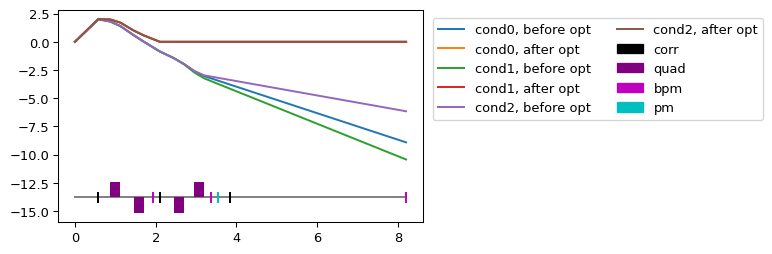

In [18]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],label='cond'+str(i)+', before opt')
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    i+=1
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [19]:
for name, val in zip(res.history['jacobian_var']['names'], res.history['jacobian_var']['values'][0]):
    print( name, val )

d (D10 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET 0.012670841531241983
d (D10 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET 0.0029698618903101215
d (D10 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET 0.07869495689668593
d (D10 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET 0.01864478320085272
d (D20 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET -0.007178363947252464
d (D20 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET -0.0024985731180674486
d (D20 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET -0.12688739220840684
d (D20 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET -0.04450568435150237


In [20]:
res.history['decision_CSETs']['values'][-1]

array([-1.80752205, 33.05206812])